## Краткое вступление в работу 

Сформируйте модель монетизации игрового приложения:

- Проведите исследовательский анализ данных
- Проанализируйте влияние событий на совершение целевого события
- Проверьте статистические гипотезы

    Проверьте гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

    Сформулировать собственную гипотезу  и проверить статистическую гипотезу относительно представленных данных. 

### Описание датасетов:

Основной датасет содержит данные о событиях, совершенных в мобильной игре "Космические братья". В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.


Датасет events.csv содержит колонки:

- event_datetime - время совершения события
- event - название события
- building_type - тип объекта строительства
- user_id - идентификатор пользователя
- project_type - тип реализованного проекта

Расшифровки событий:

- Колонка event:
    - building - Постройка объекта
    - finished_stage_1 - Окончание первого уровня
    - project - Реализация проекта
- Колонка building_type - тип объекта для постройки:
    - assembly_shop - Сборочный цех
    - spaceport - Космопорт
    - research_center - Исследовательский центр
Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет ad_cost.csv содержит колонки:

- day - день, в который был совершен клик по объявлению
- source - источник трафика
- cost - стоимость кликов

Датасет user_source.csv содержит колонки:

- user_id - идентификатор пользователя
- source - источников, с которого пришёл пользователь, установивший приложение.

## Предобработка данных

Считываем и ознакамливаемся  с данными. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

import scipy.stats

In [2]:
users = pd.read_csv('user_source.csv')

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [4]:
users.duplicated().sum()

0

Пропусков в столбцах нет, типы данных корректны. C дубликатами вроде тоже разобрались. 

In [5]:
events = pd.read_csv('events.csv')
costs =  pd.read_csv('ad_costs.csv')

In [6]:
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [7]:
events.duplicated().sum()

1

Необходимо будет исследовать пропуски в столбцах project_type,building_type, так же изменить тип данных в столбце event_datetime. 

Имеется дубликат, нужно будет исследовать природу. 

In [8]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [9]:
costs.duplicated().sum()

0

Пропусков нет, но необходимо будет изменить тип данных в столбце day.

## Непосредственная обработка 

Так как в столбце event несколько событий и они не все связаны с событием building, то конечно же имеются пропуски. 
Заполню пропуски маркером, чтобы знать, что в событиях  отличных от building, в принципе ничего не должно быть.


In [10]:
events.groupby('event').agg({'building_type':'count'})
events['building_type'] = events['building_type'].fillna(value = '-1')


В столбце project_type видимо хранится информация только о прохождении уровня через реализацию проекта, а такого события как победа над врагом не отображается, поэтому и имеются пропуски в таких событиях как finished_stage_1 и building.
Заполним пропуски так же маркером. 

In [11]:
events.groupby('event').agg({'project_type':'count'})
events['project_type'] = events['project_type'].fillna(value = '-1')

Меняем тип данных в столбце event_datetime. 

In [12]:
events['event_datetime'] = pd.to_datetime(events['event_datetime'])
events.drop_duplicates()
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null datetime64[ns]
event             135640 non-null object
building_type     135640 non-null object
user_id           135640 non-null object
project_type      135640 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


Меняем тип данных в столбце day. 

In [13]:
costs['day'] = pd.to_datetime(costs['day'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null datetime64[ns]
cost      28 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


## Исследовательский анализ. 

Исследуем на выбросы. Обнаружили редкие выбивающиеся значения в таблице costs, в столбце cost. Посредством диаграммы размаха, который нам помог вычислить выбросы. Видим на диаграмме размаха, что редкие выбивающиеся значения идут в районе 600. Поэтому убираем эти данные из графика, так как они нам точно не помогут оценить реальные данные. 

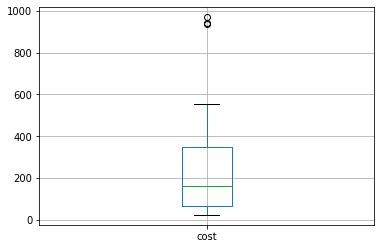

In [14]:
costs.boxplot()

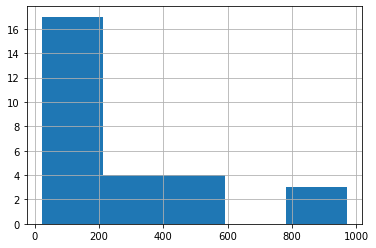

In [15]:
costs['cost'].hist(bins = 5)

In [16]:
#costs = costs.query('cost <= 600')

Убираем значения выбивающиеся значения.

## Полное исследование продукта

- Посмотреть количество юзеров в когорте.

In [17]:
print('Количество уникальных играющих юзеров:',users['user_id'].nunique())

Количество уникальных играющих юзеров: 13576


- Сколько юзеров пользуются(играют)в день,неделю(DAU, WAU)

Чтобы посчитать каждодневное  и недельное использование для начала выделим необходимую когорту пользователей с 4 по 10 мая,затем выделим в отдельные столбцы  неделю, год и полную дату.После этого рассчитаем dau и wau сгруппируем данные по уникальным пользователям и найдём среднее: 

In [18]:

events['date'] = events['event_datetime'].dt.date  
first_event_date1 = events.groupby(['user_id'])['date'].min().reset_index()
first_event_date1['date'] = pd.to_datetime(first_event_date1['date'])
first_event_date1['year'] = first_event_date1['date'].dt.year
first_event_date1['week'] = first_event_date1['date'].dt.week
first_event_date1

,user_id,date,year,week
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,2020,19
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,2020,19
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,2020,19
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,2020,19
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,2020,19
...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04,2020,19
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,2020-05-04,2020,19
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04,2020,19
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,2020-05-04,2020,19


In [19]:
dau_total = first_event_date1.groupby('date').agg({'user_id': 'nunique'}).mean()
print('Количество уникальных пользователей в день:',dau_total)
wau_total = first_event_date1.groupby(['year', 'week']).agg({'user_id': 'nunique'}).mean()
print('Количество уникальных пользователей в неделю:',wau_total)

Количество уникальных пользователей в день: user_id    1939.428571
dtype: float64
Количество уникальных пользователей в неделю: user_id    13576.0
dtype: float64


- Вовлечение пользователей.В  этом нам поможет показатель Retention Rate. Он показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность в мобильном приложении.

In [20]:
first_event_date = events.groupby(['user_id'])['date'].min()
first_event_date.name = 'first_event_date'  
user_activity = events.join(first_event_date,on='user_id')
user_activity['date'] = pd.to_datetime(user_activity['date'])
user_activity['first_event_date'] = pd.to_datetime(user_activity['first_event_date'])


Формируем когорты по дням.Затем для датафрейма рассчитаем lifetime пользователя в рамках когорты. 

In [21]:
user_activity['cohort_lifetime'] = user_activity['date'] - user_activity['first_event_date']
user_activity['cohort_lifetime'] = (user_activity['cohort_lifetime']/ np.timedelta64(1,'D')).round()
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].astype(int)
user_activity

,event_datetime,event,building_type,user_id,project_type,date,first_event_date,cohort_lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,-1,2020-05-04,2020-05-04,0
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,-1,2020-05-04,2020-05-04,0
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,-1,2020-05-04,2020-05-04,0
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,-1,2020-05-04,2020-05-04,0
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,-1,2020-05-04,2020-05-04,0
...,...,...,...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,-1,2020-06-05,2020-05-06,30
135636,2020-06-05 02:25:12,finished_stage_1,-1,515c1952-99aa-4bca-a7ea-d0449eb5385a,-1,2020-06-05,2020-05-07,29
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,-1,2020-06-05,2020-05-07,29
135638,2020-06-05 12:12:27,finished_stage_1,-1,32572adb-900f-4b5d-a453-1eb1e6d88d8b,-1,2020-06-05,2020-05-07,29


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый день. 

In [22]:
cohorts = user_activity.groupby(['first_event_date','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
cohorts

,first_event_date,cohort_lifetime,user_id
0,2020-05-04,0,5860
1,2020-05-04,1,3021
2,2020-05-04,2,3204
3,2020-05-04,3,3412
4,2020-05-04,4,3564
...,...,...,...
194,2020-05-10,19,7
195,2020-05-10,20,3
196,2020-05-10,21,1
197,2020-05-10,22,1


Найдём исходное количество пользователей в когорте.

In [23]:
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_event_date','user_id']]
inital_users_count = inital_users_count.rename(columns={'user_id':'cohort_users'})
inital_users_count

,first_event_date,cohort_users
0,2020-05-04,5860
32,2020-05-05,3361
61,2020-05-06,1847
92,2020-05-07,1109
122,2020-05-08,688
149,2020-05-09,440
175,2020-05-10,271


Объединим данные по когортам с исходным количеством пользователей в когорте:

In [24]:
cohorts = cohorts.merge(inital_users_count,on='first_event_date')
cohorts1 = cohorts.query('cohort_lifetime !=0')

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте. И построим сводную таблицу. 

In [25]:
cohorts1['retention'] = cohorts1['user_id']/cohorts1['cohort_users']
retention_pivot = cohorts1.pivot_table(index='first_event_date',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


cohort_lifetime,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
first_event_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,0.515529,0.546758,0.582253,0.608191,0.641297,0.710068,0.465529,0.427304,0.405973,0.364505,...,0.007338,0.004949,0.003242,0.002048,0.001024,0.000683,0.000341,0.000171,0.000341,0.000341
2020-05-05,0.536447,0.566201,0.612318,0.634633,0.687891,0.472776,0.451056,0.408807,0.380839,0.333234,...,0.006843,0.004760,0.002678,0.002380,0.000893,0.000595,0.000298,NaN,NaN,NaN
2020-05-06,0.519762,0.551164,0.605306,0.662696,0.434218,0.443963,0.434759,0.371413,0.332431,0.310233,...,0.004873,0.005414,0.002166,0.001624,0.001624,0.002166,0.000541,0.000541,0.000541,NaN
2020-05-07,0.507665,0.552750,0.599639,0.382326,0.400361,0.459874,0.390442,0.329125,0.291253,0.259693,...,0.009919,0.006312,0.002705,0.005410,0.002705,0.002705,0.002705,0.002705,NaN,NaN
2020-05-08,0.482558,0.545058,0.351744,0.380814,0.414244,0.440407,0.376453,0.261628,0.312500,0.222384,...,0.004360,0.007267,0.001453,NaN,0.002907,0.001453,NaN,NaN,NaN,NaN
2020-05-09,0.479545,0.320455,0.338636,0.436364,0.390909,0.420455,0.381818,0.270455,0.215909,0.209091,...,0.006818,0.002273,0.002273,0.002273,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-10,0.254613,0.298893,0.328413,0.339483,0.413284,0.435424,0.369004,0.210332,0.210332,0.228782,...,0.003690,0.003690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее используем тепловую карту для более наглядной картины) 

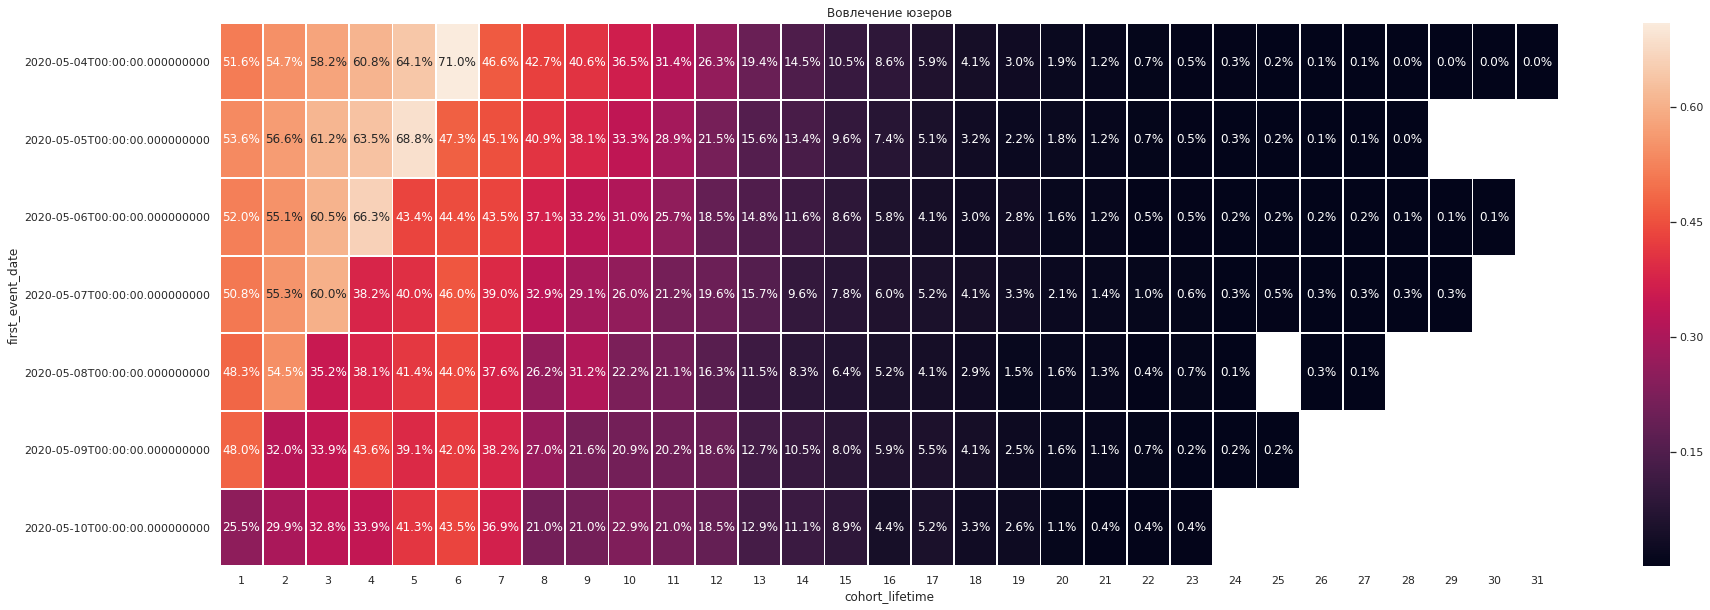

In [26]:
sns.set(style='white')
plt.figure(figsize=(30, 10))
plt.title('Вовлечение юзеров')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white')
plt.show()

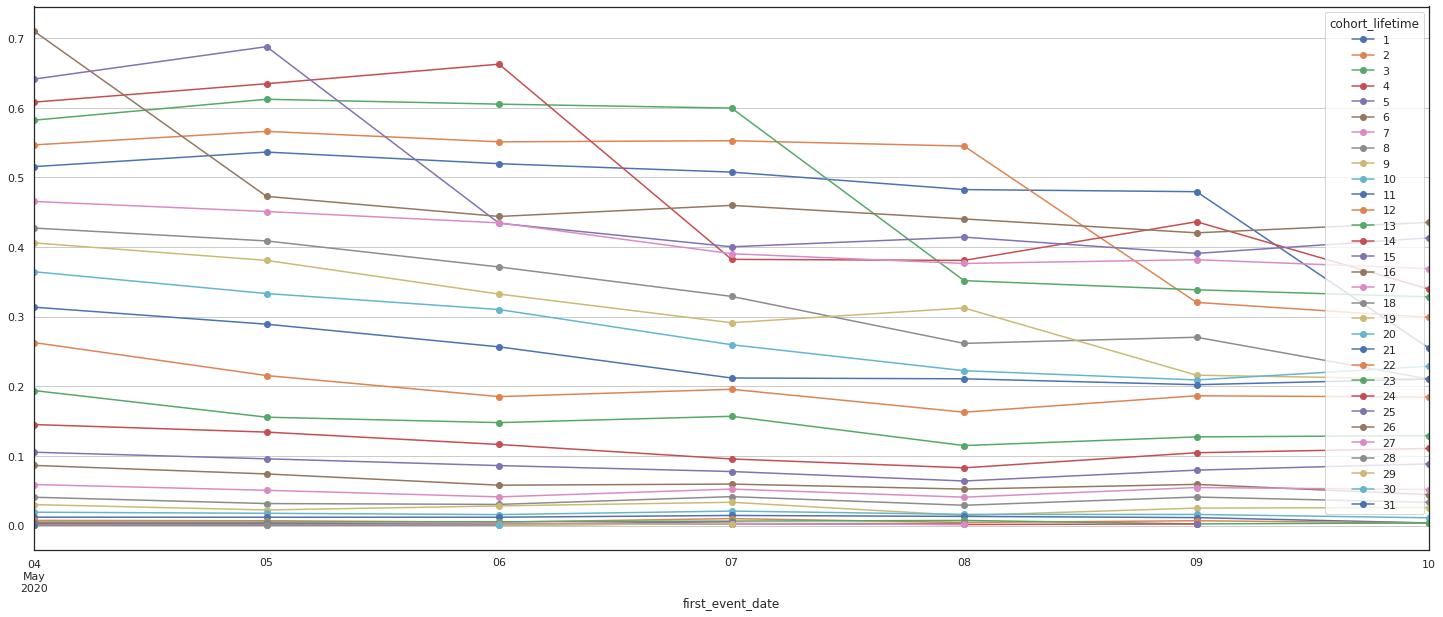

In [27]:
retention_pivot.plot(grid = True, figsize = (25, 10), style = 'o-');


Вовлеченность пользователей с 4 по 10 мая остается практически на одном уровне, только 10 мая есть небольшй спад чуть ли не в половину, возможно это из за того, что на этот день выпал праздничный день.  

- С какого источника пришло больше юзеров за весь период. 

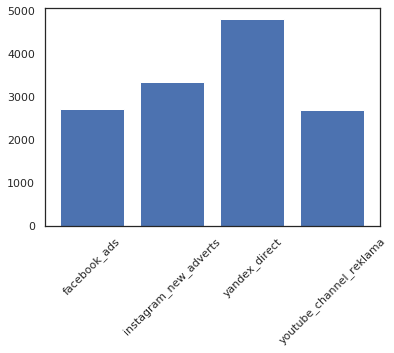

In [28]:
count = users.groupby('source').agg({'user_id':'nunique'}).reset_index()
plt.bar(count['source'], count['user_id'])
plt.xticks(rotation=45)
plt.show()


Самым эффективным источником привлечения является instagram, yandex.

И посмотрим на цифры в долях от общего количества пришедших юзеров. 

In [29]:
count['user_id']/users['user_id'].count()

0    0.200796
1    0.246538
2    0.354817
3    0.197849
Name: user_id, dtype: float64

- Из какого источника было больше удержаний юзеров.Так же рассчитываем Retention Rate только теперь акцентируем внимание на источники привлечения. 


Для этого объединим таблицы с данными по привлеченным юзерам из источников и таблицу, содержащую все необходимые данные по временным интервалам. 

In [30]:
user_source = user_activity.merge(users, on = 'user_id')
user_source

,event_datetime,event,building_type,user_id,project_type,date,first_event_date,cohort_lifetime,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,-1,2020-05-04,2020-05-04,0,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,-1,2020-05-05,2020-05-04,1,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,-1,2020-05-05,2020-05-04,1,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,-1,2020-05-05,2020-05-04,1,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,-1,2020-05-06,2020-05-04,2,youtube_channel_reklama
...,...,...,...,...,...,...,...,...,...
135635,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,-1,2020-05-13,2020-05-10,3,facebook_ads
135636,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,-1,2020-05-18,2020-05-10,8,facebook_ads
135637,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,-1,2020-05-10,2020-05-10,0,youtube_channel_reklama
135638,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,-1,2020-05-13,2020-05-10,3,youtube_channel_reklama


Далее проделываем всё тоже самое, что при рассчете Retention Rate по когортам. 

In [31]:
cohorts_source = user_source.groupby(['cohort_lifetime','source']).agg({'user_id':'nunique'}).reset_index()
cohorts_source

,cohort_lifetime,source,user_id
0,0,facebook_ads,2726
1,0,instagram_new_adverts,3347
2,0,yandex_direct,4817
3,0,youtube_channel_reklama,2686
4,1,facebook_ads,1436
...,...,...,...
118,29,youtube_channel_reklama,1
119,30,facebook_ads,1
120,30,instagram_new_adverts,1
121,30,yandex_direct,1


In [32]:
inital_users_count = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['user_id', 'source']]
inital_users_count = inital_users_count.rename(columns={'user_id':'cohort_users'})
inital_users_count

,cohort_users,source
0,2726,facebook_ads
1,3347,instagram_new_adverts
2,4817,yandex_direct
3,2686,youtube_channel_reklama


In [33]:
cohorts_source = cohorts_source.merge(inital_users_count,on='source')
cohorts_source1 = cohorts_source.query('cohort_lifetime !=0')


In [34]:
cohorts_source1['retention'] = cohorts_source1['user_id']/cohorts_source1['cohort_users']
cohorts_source1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,cohort_lifetime,source,user_id,cohort_users,retention
1,1,facebook_ads,1436,2726,0.526779
2,2,facebook_ads,1526,2726,0.559795
3,3,facebook_ads,1590,2726,0.583272
4,4,facebook_ads,1561,2726,0.572634
5,5,facebook_ads,1617,2726,0.593177
...,...,...,...,...,...
118,24,youtube_channel_reklama,6,2686,0.002234
119,25,youtube_channel_reklama,4,2686,0.001489
120,26,youtube_channel_reklama,2,2686,0.000745
121,27,youtube_channel_reklama,2,2686,0.000745


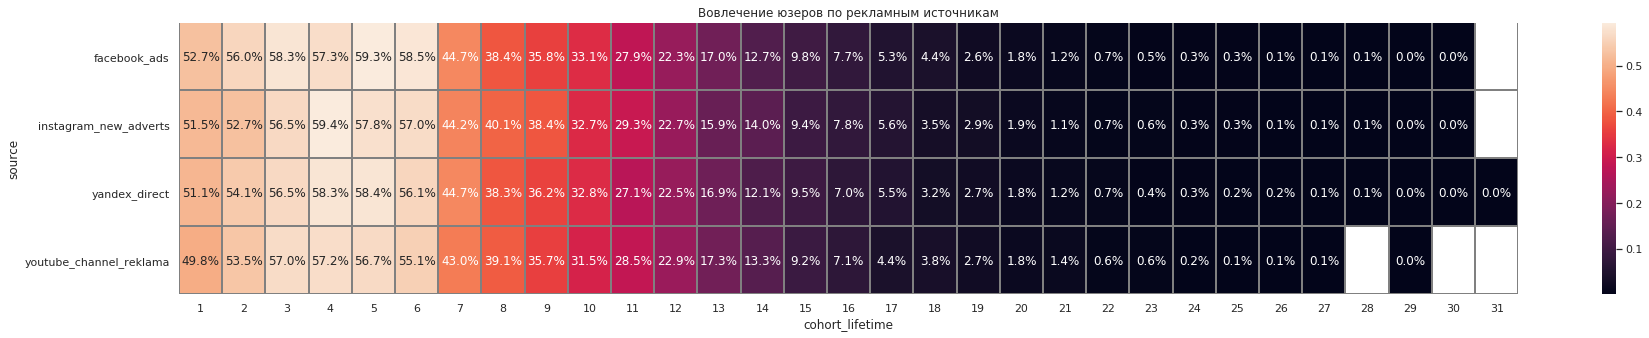

In [35]:
source_pivot = cohorts_source1.pivot_table(index= 'source',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(30, 5))
plt.title('Вовлечение юзеров по рекламным источникам')
sns.heatmap(source_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

Вовлеченность пользователей по рекламным источникам практически на одном уровне. 

## Основное исследование на средство монетизации.

- Посмотреть какой путь(событие)  выбирают юзеры чаще при прохождении уровня. 

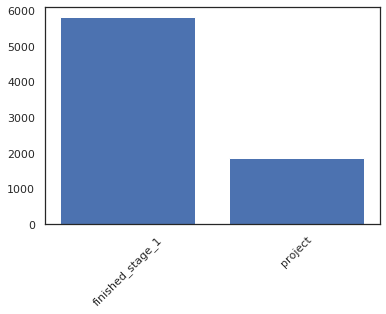

In [36]:
way = events.groupby(['event']).agg({'user_id':'count'}).reset_index()
way1 =way.query('event == ["project", "finished_stage_1"]')
plt.bar(way1['event'], way1['user_id'])
plt.xticks(rotation=45)
plt.show()


- Время прохождения уровня, в зависимости от выбранного пути прохождения

Для того, чтобы ответить на данный вопрос используем среднюю продолжительность прохождения уровня. Для этого найдем первое событие пользователя, последнее событие. 

In [37]:
first_event = events.groupby(['user_id'])['event_datetime'].min()
max_event = events.groupby(['user_id'])['event_datetime'].max()
first_event.name = 'first_event'
max_event.name = 'max_event'

Затем созданные датафреймы с минимальным и максимальным событиям присоединяем к основному с датафрейму с событиями(events), затем делаем срезы по интересуемым событиям, после чего вычитаем и находим среднее. 

In [38]:
user_activ = events.join(first_event,on='user_id')
user_ac = user_activ.join(max_event,on='user_id')
finished_stage_1 = user_ac.query('event == "finished_stage_1"')
project = user_ac.query('event == "project"')

In [39]:
finished_stage_1['stage_1'] = (finished_stage_1['max_event'] - finished_stage_1['first_event']).dt.seconds
mean_finished_stage_1 = finished_stage_1['stage_1'].mean()
print('Среднее время прохождения уровня "победа над врагом": ', mean_finished_stage_1)

Среднее время прохождения уровня "победа над врагом":  42984.254942410174


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
project['project'] = (project['max_event'] - project['first_event']).dt.seconds
mean_project = project['project'].mean()
print('Среднее время прохождения уровня "реализация проекта":' , mean_project)


Среднее время прохождения уровня "реализация проекта": 42843.99035369775


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Где в среднем получается пользователи проходят по 11 часов, в двух случаях. 

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


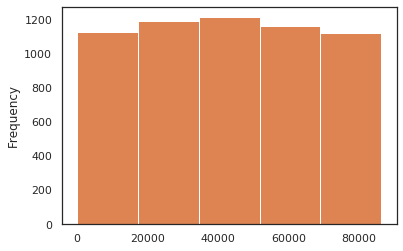

In [41]:
names = [project['project'],finished_stage_1['stage_1']]
for i in names: 
    print(i.plot(y = i,  kind='hist', bins = 5));

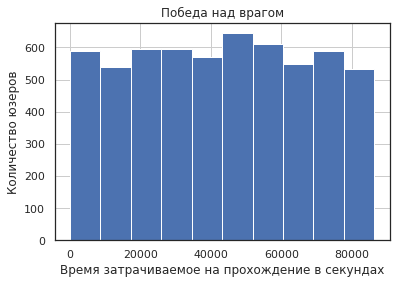

In [42]:
finished_stage_1['stage_1'].hist();
plt.xlabel('Время затрачиваемое на прохождение в секундах');
plt.ylabel('Количество юзеров');
plt.title('Победа над врагом');

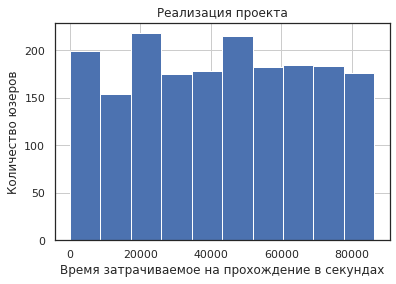

In [43]:
project['project'].hist(); 
plt.title('Реализация проекта')
plt.xlabel('Время затрачиваемое на прохождение в секундах');
plt.ylabel('Количество юзеров');

Как видим из распределения они практически индентичны. 

In [58]:
way1

,event,user_id
1,finished_stage_1,5817
2,project,1866


А вот и количество событий двух вариантов при прихождении первого уровня) 

- Исследование по какой цене можно вставлять рекламу, для того, чтобы проект был окупаем: 
  - 1. Сколько денег потратили? Всего / на каждый источник / по времени
  - 2.Сколько стоило привлечение одного покупателя из каждого источника?

Сколько денег потратили всего. 

In [45]:
costs['cost'].sum()

7603.576986788022

На каждый источник. 

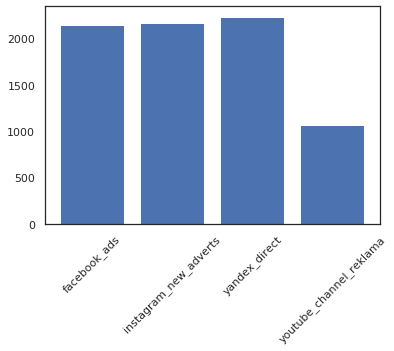

,source,cost
0,facebook_ads,2140.904643
1,instagram_new_adverts,2161.441691
2,yandex_direct,2233.111449
3,youtube_channel_reklama,1068.119204


In [46]:
total_cost = costs.groupby('source').agg({'cost':'sum'}).reset_index()
#total_cost.plot(grid = True, figsize = (25, 10), style = 'o-')
plt.bar(total_cost['source'], total_cost['cost'])
plt.xticks(rotation=45)
plt.show()
total_cost

In [47]:
total_user = events['user_id'].nunique()
total_user

13576

И посмотрели сколько же денег уходит на одного юзера в общем без разбивки на дату с каждого источника. 

In [48]:
print(total_cost['cost']/total_user)
print(count)

0    0.157698
1    0.159210
2    0.164490
3    0.078677
Name: cost, dtype: float64
                    source  user_id
0             facebook_ads     2726
1    instagram_new_adverts     3347
2            yandex_direct     4817
3  youtube_channel_reklama     2686


По времени

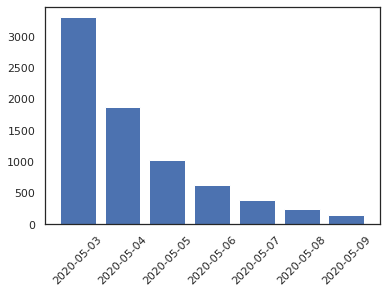

   costs_day         cost
0 2020-05-03  3302.451840
1 2020-05-04  1865.004649
2 2020-05-05  1029.431469
3 2020-05-06   620.476519
4 2020-05-07   391.852033
5 2020-05-08   242.767553
6 2020-05-09   151.592924


In [49]:
costs['costs_day'] = costs['day'].astype('datetime64[D]')
cohort_grouped1 = costs.groupby('costs_day').agg({'cost':'sum'}).reset_index()
cohort_grouped1
plt.bar(cohort_grouped1['costs_day'], cohort_grouped1['cost'])
plt.xticks(rotation=45)
plt.show()
print(cohort_grouped1)

Сколько стоило привлечение одного покупателя из каждого источника? Рассчитываем САС. 

In [50]:
users_cost= users.merge(costs, on = 'source')

Построили сводную таблицу по каждому источнику с общей стоимостью в  разбивке  по дням. 

In [51]:
cost = costs.pivot_table(index = 'day', columns = 'source', values = 'cost', aggfunc = 'sum')
cost

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-03,935.882786,943.204717,969.139394,454.224943
2020-05-04,548.354480,502.925451,554.651494,259.073224
2020-05-05,260.185754,313.970984,308.232990,147.041741
2020-05-06,177.982200,173.071145,180.917099,88.506074
2020-05-07,111.766796,109.915254,114.429338,55.740645
2020-05-08,68.009276,71.578739,62.961630,40.217907
2020-05-09,38.723350,46.775400,42.779505,23.314669


И построили сводную таблицу с количеством юзеров в  разбивке  по дням. 

In [52]:
source = users_cost.groupby(['day', 'source']).agg({'user_id':'nunique'}).reset_index()
source_id = source.pivot_table(columns = 'source', index = 'day', values = 'user_id', aggfunc = 'sum')

Для того, чтобы рассчитать расходы на каждого покупателя, необходимо расситать CAC. Для этого поделим одну таблицу на другую. 
Точнее поделим расходы за этот месяц на количество людей в когорте. 

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-03,0.343317,0.281806,0.201191,0.169108
2020-05-04,0.201157,0.150262,0.115145,0.096453
2020-05-05,0.095446,0.093807,0.063989,0.054744
2020-05-06,0.065291,0.051709,0.037558,0.032951
2020-05-07,0.041000,0.032840,0.023755,0.020752
2020-05-08,0.024948,0.021386,0.013071,0.014973
2020-05-09,0.014205,0.013975,0.008881,0.008680


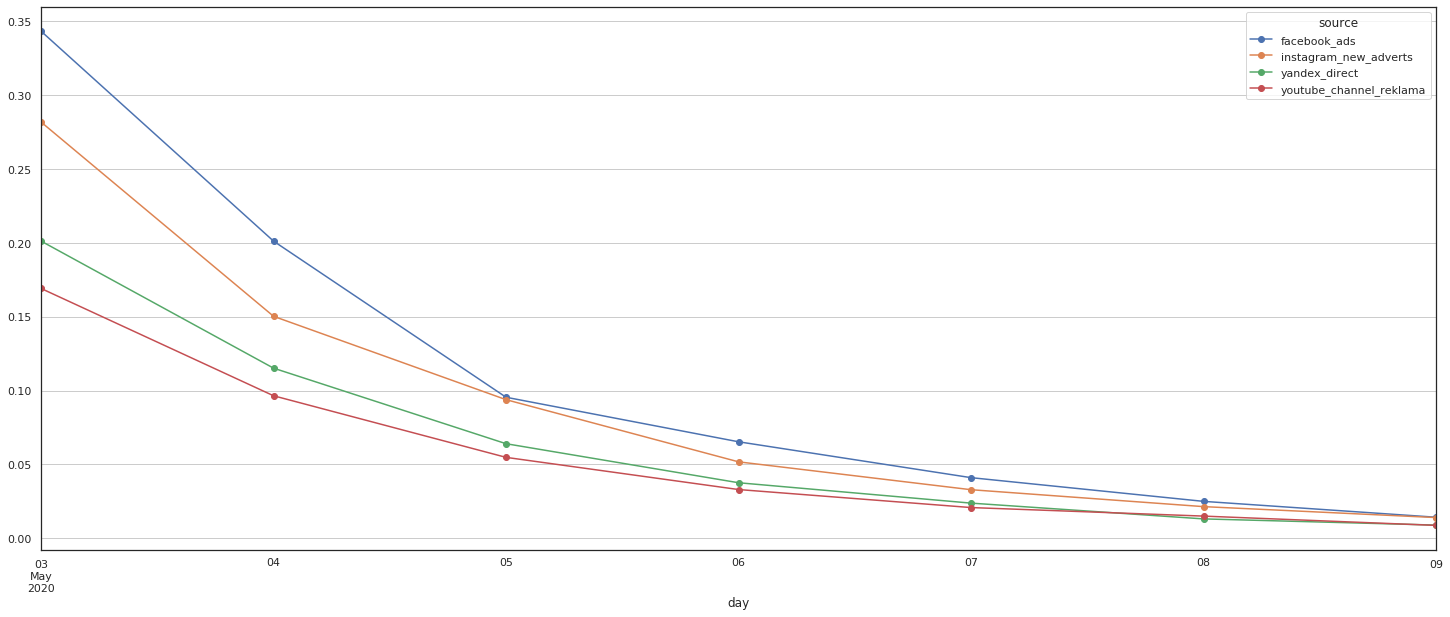

In [53]:
Cac = cost/source_id
Cac.plot(grid = True, figsize = (25, 10), style = 'o-')
Cac

In [54]:
print(total_cost['cost']/total_user)
print(count)

0    0.157698
1    0.159210
2    0.164490
3    0.078677
Name: cost, dtype: float64
                    source  user_id
0             facebook_ads     2726
1    instagram_new_adverts     3347
2            yandex_direct     4817
3  youtube_channel_reklama     2686


Учитывая, что самыми привлекаемые являются instagram и yandex они же в свою очередь являются самыми дорогими по привлечению, то мне кажется, необходимо ставить цену за рекламу, не ниже  чем привлечение юзера с этих источников. 

## Проверка гипотез

Проверить гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

Гипотеза Н0: Время прохождения не отличается


Гипотеза H1: Есть различия

In [55]:
alpha = .05
rv1=scipy.stats.norm.rvs(project['project'])
rv2=scipy.stats.norm.rvs(finished_stage_1['stage_1'])
results = scipy.stats.ttest_ind(rv1, rv2, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8306821464403148
Не получилось отвергнуть нулевую гипотезу


У нас есть две выборки в данном случае это выборки по времени прохождения уровней двумя разными вариантами и мы хотим проверить, имеют ли эти выборки одинаковые статистические свойства, то есть проверяем две гипотезы , которые взяли за основу, гипотеза H0 и H1. Критический уровень значимости  alpha взяли 0.05. Получаем p-value и сравниваем с alpha. 
В данном случаем получаем, наш метод показывает, что различий между двумя вариантами прохождени уровня нет. 

Вторая гипотеза: выберем два источника с которого пришло больше всего юзеров и проверим гипотезу о том, являются ли эти источники одинаково затратными или нет(тем более два источника с которого пришло больше всего юзеров являются дорогостоящими) 

Н0: Расходы  не отличаются


H1: Есть различия 

In [56]:
instagram = costs.query('source == "instagram_new_adverts"')
yandex = costs.query('source == "yandex_direct"')
yandex

,source,day,cost,costs_day
14,yandex_direct,2020-05-03,969.139394,2020-05-03
15,yandex_direct,2020-05-04,554.651494,2020-05-04
16,yandex_direct,2020-05-05,308.232990,2020-05-05
17,yandex_direct,2020-05-06,180.917099,2020-05-06
18,yandex_direct,2020-05-07,114.429338,2020-05-07
19,yandex_direct,2020-05-08,62.961630,2020-05-08
20,yandex_direct,2020-05-09,42.779505,2020-05-09


In [57]:
alpha = .05
rv3=scipy.stats.norm.rvs(instagram['cost'])
rv4=scipy.stats.norm.rvs(yandex['cost'])
results= scipy.stats.ttest_ind(rv3, rv4, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9556183851342829
Не получилось отвергнуть нулевую гипотезу


У нас есть две выборки в данном случае это выборки по расходам двух рекламных источников  и мы хотим проверить, имеют ли эти выборки одинаковые статистические свойства, то есть проверяем две гипотезы , которые взяли за основу, гипотеза H0 и H1. Критический уровень значимости  alpha взяли 0.05. Получаем p-value и сравниваем с alpha. 
В данном случаем получаем, что наш метод показывает, что различий между расходами дсух рекламных источников нет.

## Рекомендации: 
- По рекламным источникам хотелось бы отметить, что дорогие источники привлекают больше  новых пользователей, то есть данные источники себя оправдывают. 
- Учитывая, что самыми привлекаемые являются instagram и yandex они же в свою очередь являются самыми дорогими по привлечению, то мне кажется, необходимо ставить цену за рекламу, не ниже  чем привлечение одного  юзера с этих источников. За основу возьму цифру, предствленную в проекте, то есть 0.164, цена привлечения одного юзера с самого дорого рекламного источника yandex)  
- Юзеры затрачивают равноценное количество времени на прохождение уровня вне зависимости от того, какой вариант прохождения был выбран. Вставлять рекламу можно в два  варианта прохождения игры. 
- Рекомендации по средствам монетизации в игре, монетизировать можно не только вставкой рекламой, так же можно рассмотреть другие варианты, к примеру: 
- Чит-код который используется в компьютерных играх для добавления чего-либо полезного:  можно продавать всякие фишечки, для того, чтобы проходить уровень намного быстрее, сюда отнесу так же продажа контента. 
- Так же для того, чтобы открывать доступ к следующему уровню можно рассмотреть такие варианты как : либо плати, либо жди(это соответстенно реклама), либо пригласи друга, таким образом будем расширять круг пользователей. 


Ссылка на презентацию: 
https://yadi.sk/i/fX2Qy9vzxCKSgg